**This notebook accompanies the ph step of the pipeline.**

In [9]:
import ops
from ops.imports_ipython import *
import ops.firesnake
from ops.firesnake import Snake
import ops.qc
from glob import glob
from microfilm import microplot
from microfilm.microplot import Micropanel

# Set screen directories
ph_function_home = "/lab/barcheese01/screens"
ph_function_dataset = "baker"

# Set home directory as a combination of parse_function_home and parse_function_dataset
home = os.path.join(ph_function_home, ph_function_dataset)

### Run ph snakemake pipeline on one well / tile combination

In [5]:
# Set parameters for image processing
SMOOTH = 5
RADIUS = 30
THRESHOLD_DAPI = 2500
NUCLEUS_AREA = (250, 3500)

# Set channel information
BACKGROUND_CHANNEL = 3  # Membrane channel
FOCI_CHANNEL = 1  # Cenpa channel

# Define threshold values
BACKGROUND_THRESHOLD_OFFSET = 80
BACKGROUND_QUANTILE = {'low': 0.05, 'mid': 0.025, 'high': 0.01}
CELL_COUNT_THRESHOLDS = (1400, 2500)
BACKGROUND_EROSION = 50
BACKGROUND_SMOOTH = 3

# Set wildcards (one well / tile combination to test on)
WELLS = 'A1'  # List of well identifiers
TILES = 186  # List of tile numbers + 1
WILDCARDS = dict(well=WELLS, tile=TILES)

# Channel information
FINAL_CHANNELS = 'DAPI-GFP-A594-AF750'
CHANNEL_NAMES=['dapi','cenpa','coxiv','wga']

# Microplot information
cmaps = ['pure_blue', 'pure_green', 'pure_yellow', 'pure_magenta']
DISPLAY_RANGES = [
    [500, 10000],
    [1000, 10000],
    [100, 7500],
    [100, 7500]
]

# Define colormap
GLASBEY_INVERTED = (ops.constants.GLASBEY_INVERTED)

In [4]:
# Define the search pattern relative to the home directory
search_pattern = 'input_ph/process/input/20X/multidimensional/20X*{well}_Tile-{tile}.phenotype.tif'.format(**WILDCARDS)
search_path = os.path.join(home, search_pattern)

# Use glob.glob to find files matching the search pattern
input_files = natsorted(glob(search_path))

# Print the found files
for f in input_files:
    print(f)

# manually change saving directory to sbs_1 directory
description = parse(input_files[0])
description['subdir'] = os.path.join(home, 'ph_2')
description

/lab/barcheese01/screens/baker/input_ph/process/input/20X/multidimensional/20X_A1_Tile-186.phenotype.tif


{'subdir': '/lab/barcheese01/screens/baker/ph_2',
 'mag': '20X',
 'well': 'A1',
 'tile': '186',
 'tag': 'phenotype',
 'ext': 'tif',
 'file': '/lab/barcheese01/screens/baker/input_ph/process/input/20X/multidimensional/20X_A1_Tile-186.phenotype.tif'}

##### load, align

In [6]:
data = read(input_files[0])
data.shape
save(name(description, tag='original'), data)
print(data.shape) # expected dimensions of (CHANNEL, I, J)
# aligns phenotype data using dapi, with source and rider channels
aligned = Snake._align_phenotype_channels(data, target=0, source=2, riders = [], remove=False)
# save(name(description, tag='aligned'), aligned)

(4, 2960, 2960)


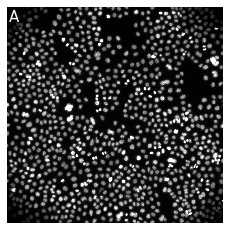

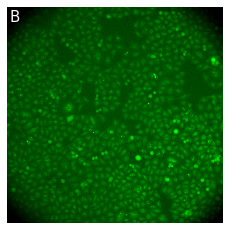

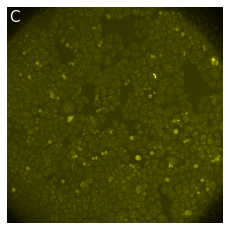

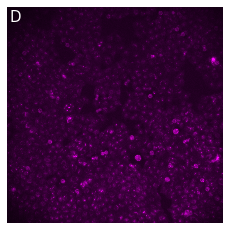

In [10]:
# Create microshow plots for each channel with specified colormaps and display ranges
microim0_ph = microplot.microshow(aligned[0], 
                               rescale_type='limits', 
                               limits=DISPLAY_RANGES[0], 
                               label_text='A', 
                               channel_names=CHANNEL_NAMES[0])

microim1_ph = microplot.microshow(aligned[1], 
                               cmaps=cmaps[1], 
                               rescale_type='limits', 
                               limits=DISPLAY_RANGES[1], 
                               label_text='B', 
                               channel_names=CHANNEL_NAMES[1])

microim2_ph = microplot.microshow(aligned[2], 
                               cmaps=cmaps[2], 
                               rescale_type='limits', 
                               limits=DISPLAY_RANGES[2], 
                               label_text='C', 
                               channel_names=CHANNEL_NAMES[2])

microim3_ph = microplot.microshow(aligned[3], 
                               cmaps=cmaps[3], 
                               rescale_type='limits', 
                               limits=DISPLAY_RANGES[3], 
                               label_text='D', 
                               channel_names=CHANNEL_NAMES[3])

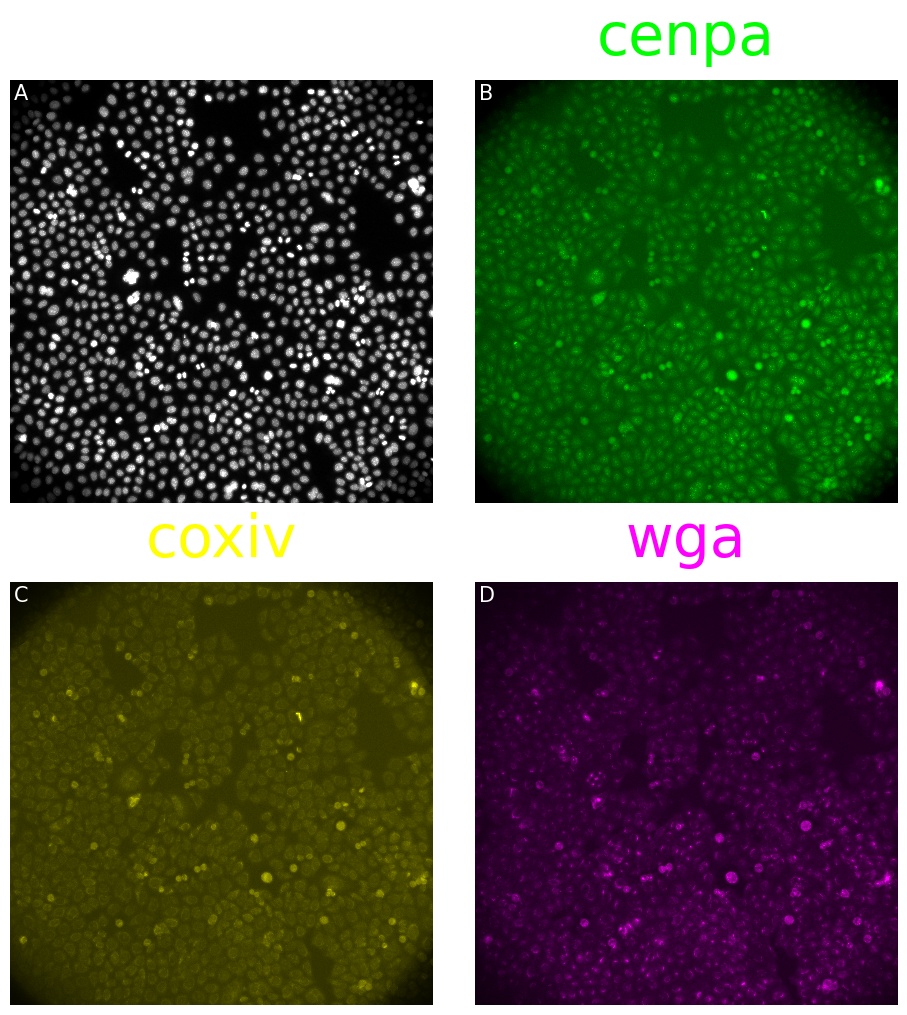

In [11]:
panel = Micropanel(rows=2, cols=2, figscaling=5)
panel.add_element([0,0], microim0_ph);
panel.add_element([0,1], microim1_ph);
panel.add_element([1,0], microim2_ph);
panel.add_element([1,1], microim3_ph);
panel.add_channel_label()

##### segment nuclei and cells

In [12]:
# segment nuclei using dapi channel, dapi intensity, radius, nucleus area thresholds
nuclei = Snake._segment_nuclei(aligned, THRESHOLD_DAPI, radius=RADIUS, area_min=NUCLEUS_AREA[0], area_max=NUCLEUS_AREA[1])
save(name(description, tag='nuclei'), nuclei, compress=1)

Number of nuclei segmented: 1164


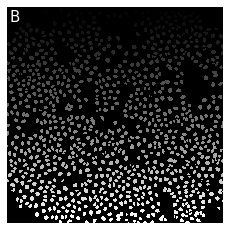

In [13]:
nuclei_microshow = microplot.microshow(nuclei, 
                                       label_text='B',
                                       channel_names='Nuclei')

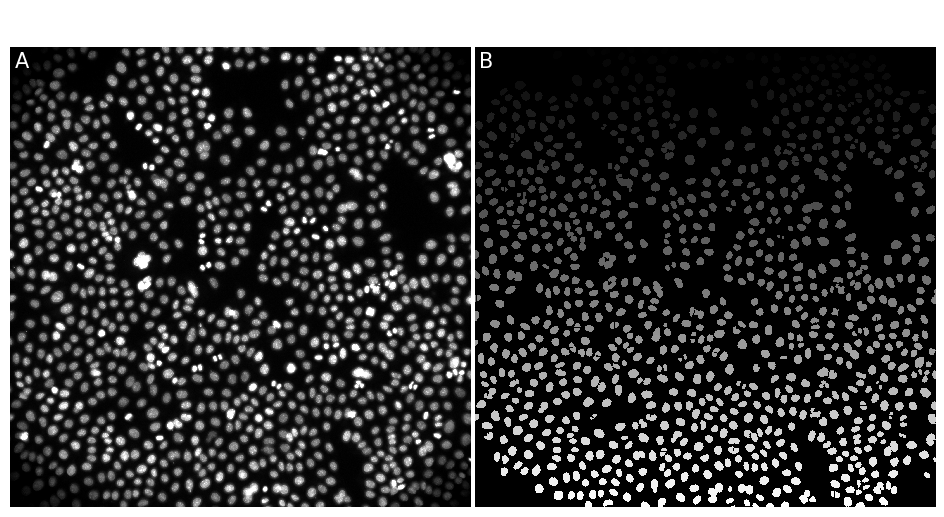

In [14]:
panel = Micropanel(rows=1, cols=2, figscaling=5)
panel.add_element([0,0], microim0_ph);
panel.add_element([0,1], nuclei_microshow);
panel.add_channel_label()

In [15]:
# set quantiles
if nuclei.max() < CELL_COUNT_THRESHOLDS[0]:
    quantile = BACKGROUND_QUANTILE['low']
elif nuclei.max() > CELL_COUNT_THRESHOLDS[1]:
    quantile = BACKGROUND_QUANTILE['high']
else:
    quantile = BACKGROUND_QUANTILE['mid']

# segment cells using background channel, nuclei, background channel parameters
cells = Snake._segment_cells_robust(aligned, channel=BACKGROUND_CHANNEL, nuclei=nuclei, background_offset=BACKGROUND_THRESHOLD_OFFSET, background_quantile=quantile, smooth=BACKGROUND_SMOOTH, erosion=BACKGROUND_EROSION)
save(name(description, tag='cells'), cells, compress=1)

Number of cells segmented: 1084


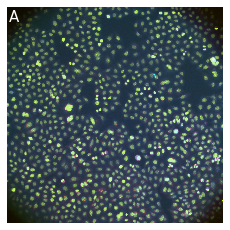

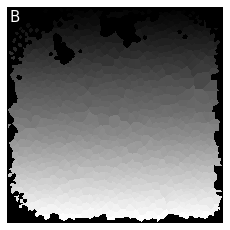

In [16]:
# Create microshow plots for each channel with specified colormaps and display ranges
all_microshow = microplot.microshow(aligned,
                                     label_text='A',
                                     rescale_type='limits', 
                                     limits=DISPLAY_RANGES,
                                     channel_names='Merged')

cells_microshow = microplot.microshow(cells, 
                                       label_text='B',
                                       channel_names='Cells')

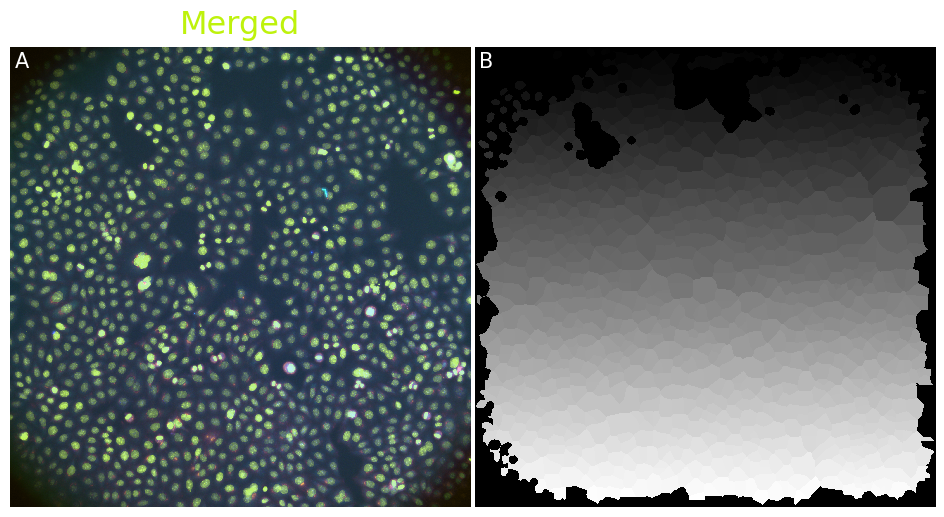

In [17]:
panel = Micropanel(rows=1, cols=2, figscaling=5)
panel.add_element([0,0], all_microshow);
panel.add_element([0,1], cells_microshow);
panel.add_channel_label()

##### extract phenotype information

In [96]:
# extract minimal phenotype information from nuclei
df_ph_info = Snake._extract_phenotype_minimal(data_phenotype=nuclei, nuclei=nuclei, wildcards=WILDCARDS)
df_ph_info.to_csv(name(description, tag='ph_info', ext='csv'), index=None)
df_ph_info.head()

,area,i,j,cell,bounds,tile,well
0,778,8.210797,1385.254499,1,"(0, 1361, 23, 1412)",186,A1
1,1176,10.578231,1637.889456,2,"(0, 1607, 27, 1665)",186,A1
2,1171,14.822374,2267.883006,3,"(0, 2246, 34, 2290)",186,A1
3,1717,15.471753,1993.456610,4,"(0, 1963, 35, 2024)",186,A1
4,1352,22.068047,1451.877219,5,"(1, 1430, 45, 1479)",186,A1


In [97]:
# extract full phenotype information from aligned images, nuclei, cells, and specifying foci_channel and channel order
df_ph = Snake._extract_phenotype_cp_multichannel(data_phenotype=aligned, nuclei=nuclei, cells=cells, foci_channel=FOCI_CHANNEL, wildcards=WILDCARDS, channel_names=CHANNEL_NAMES)
df_ph.to_csv(name(description, tag='phenotype', ext='csv'), index=None)
df_ph.head()

finding foci


/lab/barcheese01/mdiberna/OpticalPooledScreens/ops/process.py:640: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_max = skimage.feature.peak_local_max(


,label,nucleus_dapi_int,nucleus_cenpa_int,nucleus_coxiv_int,nucleus_wga_int,nucleus_dapi_mean,nucleus_cenpa_mean,nucleus_coxiv_mean,nucleus_wga_mean,nucleus_dapi_std,...,nucleus_number_neighbors_1,nucleus_percent_touching_1,nucleus_first_neighbor_distance,nucleus_second_neighbor_distance,nucleus_angle_between_neighbors,cell_number_neighbors_1,cell_percent_touching_1,cell_first_neighbor_distance,cell_second_neighbor_distance,cell_angle_between_neighbors
0,1,2529281,2986737,1452497,1011149,3251.003856,3838.993573,1866.962725,1299.677378,1055.519036,...,0,0.0,68.048587,104.470959,162.580839,NaN,NaN,NaN,NaN,NaN
1,2,5101766,4984493,2219034,1501490,4338.236395,4238.514456,1886.933673,1276.777211,961.029933,...,0,0.0,75.412932,103.322789,78.572943,NaN,NaN,NaN,NaN,NaN
2,3,5129019,4004800,1489580,1370445,4380.033305,3419.982921,1272.058070,1170.320239,710.983216,...,0,0.0,57.649908,60.337357,81.091060,NaN,NaN,NaN,NaN,NaN
3,4,8121601,7267850,3251340,2292326,4730.111241,4232.877111,1893.616773,1335.076296,802.454876,...,0,0.0,78.087072,119.777262,100.907540,NaN,NaN,NaN,NaN,NaN
4,5,6589389,5669442,2612564,1713979,4873.808432,4193.374260,1932.369822,1267.735947,948.007838,...,0,0.0,68.048587,83.766855,170.312715,NaN,NaN,NaN,NaN,NaN


### Visualize ph output from collated information across all wells

In [18]:
ph_info = pd.read_hdf('phenotype_info.hdf')

In [19]:
num_rows = len(ph_info)
print(f"The number of cells extracted in the ph step is: {num_rows}")

The number of cells extracted in the ph step is: 8389499
